<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>



# Laboratorio de Codificación de Variables Categóricas

AutoRenew, la empresa líder en la venta de coches de segunda mano, continúa con el desarrollo del modelo predictivo que ayudará a estimar el precio de los vehículos usados. Hasta ahora, has realizado un análisis exploratorio, gestionado los valores nulos y tratado los outliers en el conjunto de datos. El siguiente paso en el proceso de preprocesamiento es manejar las variables categóricas para que el modelo de machine learning pueda interpretarlas correctamente.

En este laboratorio, te centrarás en la **codificación de variables categóricas**. Dado que los modelos de machine learning requieren datos numéricos para funcionar, es crucial convertir las variables categóricas en un formato que los algoritmos puedan procesar. Trabajarás con el mismo conjunto de datos que has utilizado en los laboratorios anteriores, enfocándote ahora en transformar las columnas categóricas de manera efectiva.

**Instrucciones:**

1. **Identificación de Variables Categóricas:** Revisa el conjunto de datos e identifica las columnas que contienen variables categóricas. Estas son las columnas que contienen texto o categorías que necesitan ser transformadas en valores numéricos para ser utilizadas en el modelo de machine learning.

2. **Selección de Técnicas de Codificación:** Decide qué técnica(s) de codificación aplicar a cada variable categórica. Algunas de las opciones que tienes son:

   - **Label Encoding:** Asigna un número único a cada categoría dentro de una variable.

   - **One-Hot Encoding:** Crea nuevas columnas binarias (0/1) para cada categoría única en una variable.

   - **Target Encoding:** Utiliza la media del target (en este caso, el `price`) para codificar las categorías, si consideras que podría ser útil.

3. **Aplicación de la Codificación:** Implementa las técnicas seleccionadas en las variables categóricas. Asegúrate de revisar cómo estas transformaciones afectan el conjunto de datos y de mantener un registro de los cambios realizados.

4. **Verificación del Conjunto de Datos Transformado:** Una vez que hayas aplicado la codificación, verifica que el conjunto de datos resultante esté listo para ser utilizado en el modelo de machine learning. Asegúrate de que no queden variables categóricas sin codificar y que la estructura del conjunto de datos sea adecuada para el análisis.

**Nota:** Este laboratorio es parte de una serie continua en la que utilizas el mismo conjunto de datos a lo largo de la semana. Documenta bien los pasos que sigas, ya que esta codificación será clave para los modelos que desarrollarás más adelante.



### 0. Imports

In [1]:
# Métodos mágicos - reimportación automática de funciones src y similares
# -----------------------------------------------------------------------
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Funciones de soporte
# -----------------------------------------------------------------------
import sys
sys.path.append("..") # añadir el directorio padre al Path
import src.soporte_descriptiva as sd
import src.soporte_preprocesamiento as sp
import src.ab_testing_support as ats

# Imputación
# -----------------------------------------------------------------------
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import BayesianRidge

# Encoding para categóricas
# -----------------------------------------------------------------------
from sklearn.preprocessing import OrdinalEncoder, TargetEncoder, OneHotEncoder
import category_encoders as ce

# Cálculo de la V de Cramer
# -----------------------------------------------------------------------
from association_metrics.categorical import CramersV 

# Gestión de warnings
# -----------------------------------------------------------------------
import warnings

# Traducciones de calendario
# -----------------------------------------------------------------------
import calendar

# 1. Importar datos 

Se importan los datos con nulos gestionados, para inspeccionar qué tratamientos de encoding son más convenientes para cada variable.

In [2]:
autorenew_outliers = pd.read_parquet("../datos/autorenew_outliers.parquet")
autorenew_nulos = pd.read_csv("../datos/autorenew_sinnulos.csv", index_col=0)

# 2. Exploracion

Dado que para esta exploración se va a tener como criterio único la diferencia de distribuciones de la variable objetivo con respecto a las categóricas, sin transformaciones de datos, se seleccionan la variable objetivo y las categóricas, pasando estas últimas a tipo 'category' para facilitar su gestión.

Se consideran como categóricas las variables 'monthofregistration' y 'kilometer'. La primera debido al ciclo anual, que no puede considerarse lineal y del que, fuera del ejercicio de laboratorio, sería tal vez interesante generar variables de ciclo para ver si demuestran mayor correlación con la objetivo. La segunda, por su baja cantidad de valores únicos.

In [3]:
autorenew_df_cat = autorenew_outliers[["vehicletype","gearbox","fueltype","brand","kilometer","notrepaireddamage"]].astype("category")
autorenew_df_cat["monthofregistration"] = autorenew_nulos["monthofregistration"].astype("int")
autorenew_df_cat["price"] = autorenew_outliers["price"]
print("Comprobando los tipos de dato:\n")
autorenew_df_cat.info()

Comprobando los tipos de dato:

<class 'pandas.core.frame.DataFrame'>
Index: 360745 entries, 0 to 360744
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   vehicletype          360745 non-null  category
 1   gearbox              360745 non-null  category
 2   fueltype             360745 non-null  category
 3   brand                360745 non-null  category
 4   kilometer            360745 non-null  category
 5   notrepaireddamage    360745 non-null  category
 6   monthofregistration  360745 non-null  int64   
 7   price                360745 non-null  float64 
dtypes: category(6), float64(1), int64(1)
memory usage: 10.3 MB


Observando de nuevo las relaciones entre variables:

In [4]:
autorenew_df_cat['monthofregistration_name'] = autorenew_df_cat['monthofregistration'].map(lambda x: calendar.month_abbr[x])

In [5]:
autorenew_df_cat['monthofregistration_name'].replace("","Desconocido", inplace=True)
autorenew_df_cat['monthofregistration_name'] = autorenew_df_cat['monthofregistration_name'].astype("category")

C:\Users\Miguel\AppData\Local\Temp\ipykernel_6324\854224413.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  autorenew_df_cat['monthofregistration_name'].replace("","Desconocido", inplace=True)


In [6]:
visualizador = sp.Visualizador(autorenew_df_cat)

In [ ]:
visualizador.analisis_temporal("price","monthofregistration_name")

Realizando AB-Testing de la variable vehicletype
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.0 > alpha 0.05, en la variable vehicletype, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO



c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)["ranks"].mean()


Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos comparados son significativamente diferentes.

Las combinaciones con diferencia significativas en sus medianas, según el test de Dunn son:


,group1,group2,meddiff,p-adj,reject_H0
0,bus,combi,-300.0,0.0,True
1,bus,convertible,-1000.0,0.0,True
2,bus,coupe,-2000.0,0.0,True
3,bus,other,-2000.0,0.0,True
4,bus,small car,-2901.0,0.0,True
5,bus,suv,6300.0,0.0,True
6,combi,convertible,-700.0,0.0,True
7,combi,coupe,-1700.0,0.0,True
8,combi,other,-1700.0,0.0,True
9,combi,small car,-2601.0,0.0,True


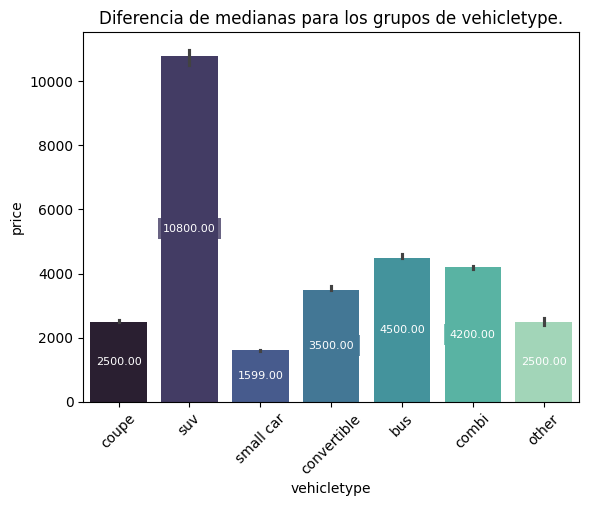

Realizando AB-Testing de la variable gearbox
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.0 > alpha 0.05, en la variable gearbox, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO



c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)["ranks"].mean()


Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos comparados son significativamente diferentes.

Las combinaciones con diferencia significativas en sus medianas, según el test de Dunn son:


,group1,group2,meddiff,p-adj,reject_H0
0,automatic,manually,-2899.0,0.0,True


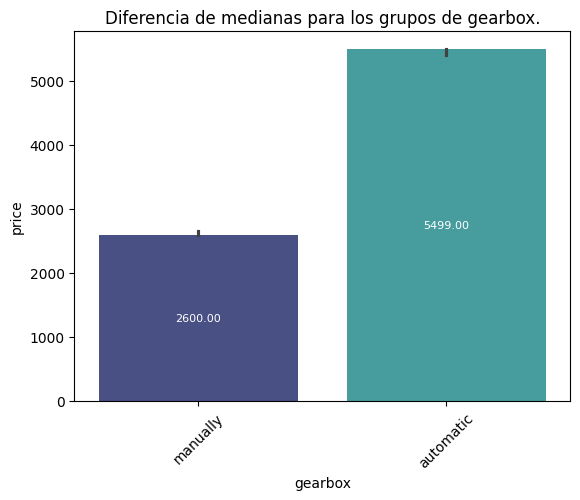

Realizando AB-Testing de la variable fueltype
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.0 > alpha 0.05, en la variable fueltype, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO



c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)["ranks"].mean()


Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos comparados son significativamente diferentes.

Las combinaciones con diferencia significativas en sus medianas, según el test de Dunn son:


,group1,group2,meddiff,p-adj,reject_H0
0,cng,diesel,2090.0,0.00,True
1,cng,electro,2399.5,0.00,True
2,cng,hybrid,-2509.5,0.00,True
3,cng,lpg,-900.0,0.05,True
4,cng,other,-2666.0,0.00,True
5,cng,petrol,-1600.0,0.00,True
7,diesel,hybrid,-4599.5,0.00,True
8,diesel,lpg,-2990.0,0.00,True
9,diesel,other,-4756.0,0.00,True
10,diesel,petrol,-3690.0,0.00,True


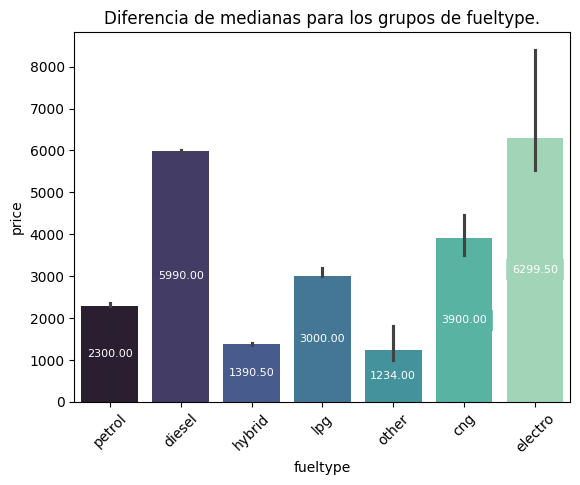

Realizando AB-Testing de la variable brand
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.0 > alpha 0.05, en la variable brand, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO



c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)["ranks"].mean()


Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos comparados son significativamente diferentes.

Las combinaciones con diferencia significativas en sus medianas, según el test de Dunn son:


,group1,group2,meddiff,p-adj,reject_H0
0,alfa_romeo,audi,3550.0,0.0,True
1,alfa_romeo,bmw,3450.0,0.0,True
2,alfa_romeo,chevrolet,2100.0,0.0,True
5,alfa_romeo,dacia,2500.0,0.0,True
6,alfa_romeo,daewoo,-1401.0,0.0,True
...,...,...,...,...,...
774,toyota,trabant,-2868.0,0.0,True
775,toyota,volkswagen,-1110.0,0.0,True
776,toyota,volvo,-1350.0,0.0,True
777,trabant,volkswagen,1758.0,0.0,True


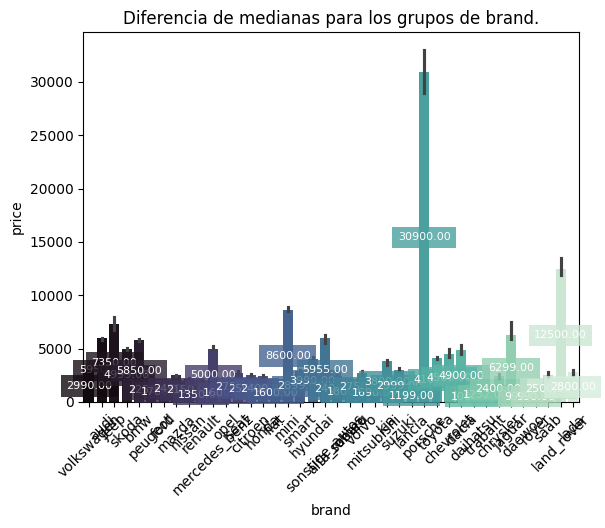

Realizando AB-Testing de la variable kilometer
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.0 > alpha 0.05, en la variable kilometer, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO



c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)["ranks"].mean()


Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos comparados son significativamente diferentes.

Las combinaciones con diferencia significativas en sus medianas, según el test de Dunn son:


,group1,group2,meddiff,p-adj,reject_H0
0,5000.0,50000.0,8800.0,0.0,True
1,5000.0,60000.0,7499.0,0.0,True
2,5000.0,70000.0,6699.0,0.0,True
3,5000.0,80000.0,5499.0,0.0,True
4,5000.0,90000.0,4499.5,0.0,True
...,...,...,...,...,...
73,150000.0,50000.0,8100.0,0.0,True
74,150000.0,60000.0,6799.0,0.0,True
75,150000.0,70000.0,5999.0,0.0,True
76,150000.0,80000.0,4799.0,0.0,True


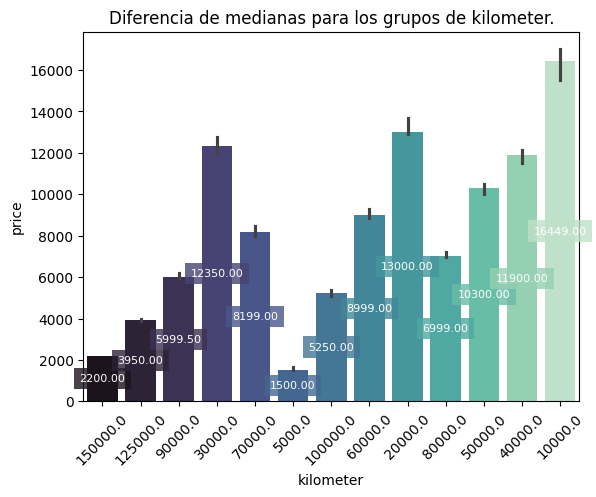

Realizando AB-Testing de la variable notrepaireddamage
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.0 > alpha 0.05, en la variable notrepaireddamage, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO



c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)["ranks"].mean()


Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos comparados son significativamente diferentes.

Las combinaciones con diferencia significativas en sus medianas, según el test de Dunn son:


,group1,group2,meddiff,p-adj,reject_H0
0,no,yes,-2498.0,0.0,True


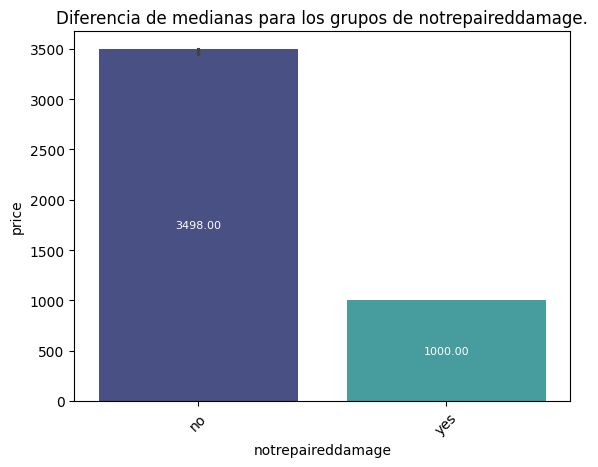

Realizando AB-Testing de la variable monthofregistration_name
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.0 > alpha 0.05, en la variable monthofregistration_name, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO



c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
c:\Users\Miguel\.virtualenvs\Semana_7_-_Preprocesamiento-tXy14D4E\Lib\site-packages\scikit_posthocs\_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)["ranks"].mean()


Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos comparados son significativamente diferentes.

Las combinaciones con diferencia significativas en sus medianas, según el test de Dunn son:


,group1,group2,meddiff,p-adj,reject_H0
2,Apr,Desconocido,-2400.0,0.000,True
3,Apr,Feb,-201.0,0.042,True
5,Apr,Jul,0.0,0.015,True
7,Apr,Mar,-300.0,0.000,True
9,Apr,Nov,100.0,0.000,True
11,Apr,Sep,100.0,0.000,True
13,Aug,Desconocido,-2250.0,0.000,True
16,Aug,Jul,150.0,0.016,True
18,Aug,Mar,-150.0,0.000,True
20,Aug,Nov,250.0,0.000,True


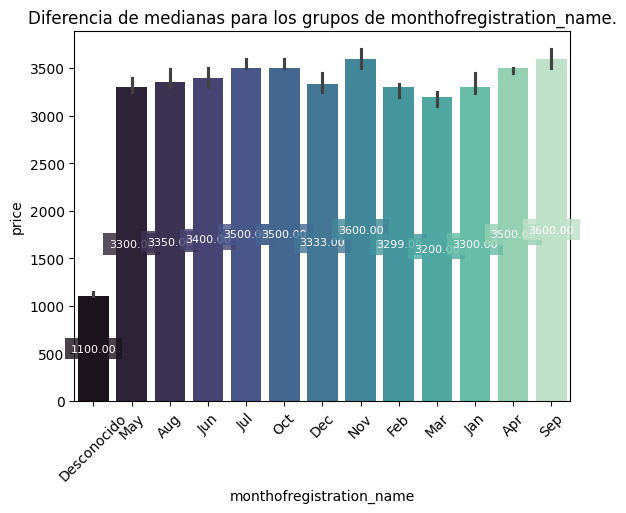

In [ ]:
for columna_categorica in autorenew_df_cat.select_dtypes("category"):
    print(f"Realizando AB-Testing de la variable {columna_categorica}")
    print("===============================================")
    tester = ats.AB_testing(autorenew_df_cat, "price", 0.05, verbose=False)
    tester.evaluar_ab_testing(columna_categorica)